# Food-101 Classification

## Part 2: Classification with Image Augmentation

In the previous notebook, we identified several features of the Food-101 dataset that makes it particularly challenging. The dataset is small, consisting of only 750 training images per class. Many of the images are amateur photographs with bad lighting or framing. There is high variability of images within a single class. A single image may also contain multiple classes (ie Hamburger and Fries) despite there being only one correct label for the image. There are also classes that contain high visual similarity to each other.

To train a model that is robust to these challenges, we need to use a few tricks.

### Dropout and Weight Decay
We will include dropout and weight decay to help regularize the model

### Progressive Resizing
First we will train on images at 256x256 resolution. After several epochs, we will scale up to 512x512 resolution. Resizing alters the receptive field of the convolutional kernels in the network relative to actual feature sizes on the image. In practice this allows us to train longer without overfitting.

### Image Augmentation
This will be our main method of attacking the small dataset. We will use an aggressive set of image augmentations to artificially expand the dataset

### Test Time Augmentation
We will predict on the test set using test time augmentation. This means that for each image in the test dataset, we will predict on several augmented versions of the image and average their prediction scores.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from shutil import copyfile

In [3]:
bs = 96

In [4]:
path = Path('../data/food-101/')
path_img = path/'images'
path_meta = path/'meta'

In [5]:
path_train = path/'data/train'

In [6]:
x = torch.rand([32, 256, 1024], device=0, requires_grad=True)

In [8]:
(x@x.transpose(1,2)).shape

torch.Size([32, 256, 256])

In [9]:
del x
gc.collect()

40

# Creating the Dataloader

We will use the fast.ai library for creating our dataloader and training our model. fast.ai has a nice image augmentation pipeline that we can use to manage our augmentation. Here we set the parameters for the different augmentation functions `do_flip`, `flip_vert`, `max_rotate`, `max_zoom`, `max_lighting` and `max_warp`. What exactly these functions do will be explained below.

In [10]:
tfms = get_transforms(
                        do_flip=True,
                        flip_vert=True,
                        max_rotate=10.0,
                        max_zoom = 1.1,
                        max_lighting=0.25,
                        max_warp=0.25,
                        )

Here we create our dataloader. In doing so we split the test data into training and validation sets. We can't use the actual test set as a validation set, that would be cheating.

We take a random 7% validation set, passing a specific random seed to the splitting function to ensure we always get the same split. The 7% validation set leads to a training set of 70448 images and a validation set of 5302 images.

In [11]:
data = (ImageList.from_folder(path_train).split_by_rand_pct(0.07, seed=42)
                                       .label_from_folder(classes=None)
                                       .transform(tfms=tfms, size=256)
                                       .databunch(bs=bs, num_workers=6))

In [12]:
data

ImageDataBunch;

Train: LabelList (70448 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ..\data\food-101\data\train;

Valid: LabelList (5302 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
clam_chowder,macaroni_and_cheese,tacos,macaroni_and_cheese,lobster_roll_sandwich
Path: ..\data\food-101\data\train;

Test: None

Examining the validation dataset on a per-class basis, it looks like we have an average representation of 52 images per class, which is about what we would expect.

In [19]:
classes = [[i1].obj for i in data.valid_ds]
df = pd.DataFrame(classes, columns=['class'])

In [24]:
df['class'].value_counts().mean(), df['class'].value_counts().std()

(52.495049504950494, 7.180005240076412, 72, 36)

# Image Augmentation Functions

Lets look at what the augmentation functions we defined earlier actually do. First we'll look at the composite effect of all augmentations, then we'll break down each augmentation function individually.

## Composite Augmentations
Here's the full effect of merging zooms, rotations, flips, perspective warping and lighting changes.

In [13]:
def get_ex():
    return open_image(path_train/'spring_rolls/85452.jpg')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(data.train_ds.tfms, **kwargs).show(ax=ax) for i, ax in enumerate(plt.subplots(
                                                                        rows, cols, figsize=(width, height))[1].flatten())]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


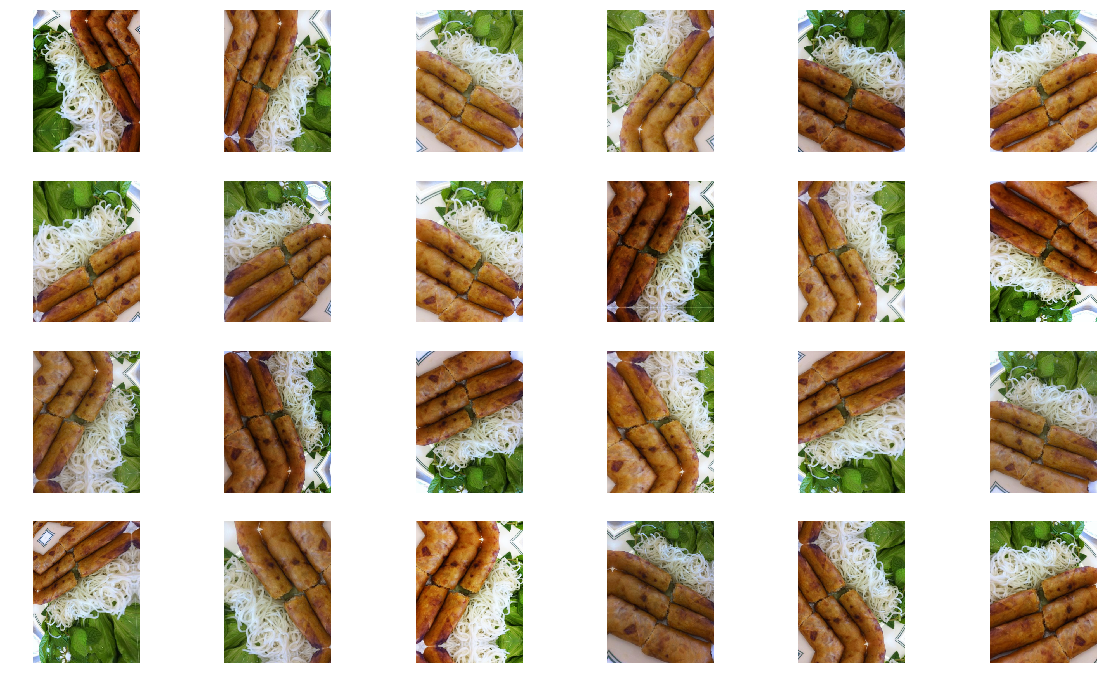

In [14]:
plots_f(4, 6, 20, 12)

# Individual Augmentations

What do these augmentation functions do individually?

In [15]:
def plots_f_indiv(idx, rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(data.train_ds.tfms[idx], **kwargs).show(ax=ax) for i, ax in enumerate(plt.subplots(
                                                                        rows, cols, figsize=(width, height))[1].flatten())]

## Augmentation 1: Dihedral Affine Transformation

Randomly rotates and flips the image. This particular augmentation function only applies discrete 90 degree rotations. The behavior of this function is determined by two parameters we passed in the augmentations list - `do_flip` and `flip_vert`. `do_flip` turns on the Dihedral Affline Transformation, and `flip_vert` specifies that we will flip the image both horizontally and vertically.

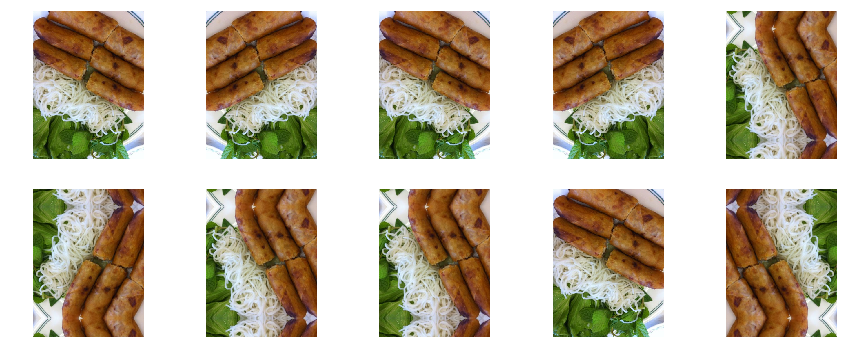

In [16]:
plots_f_indiv(1, 2, 5, 15, 6)

Choosing to pass the `flip_vert` parameter and apply vertical flipping has some interesting implications. Consider how this augmentation looks for the following image:

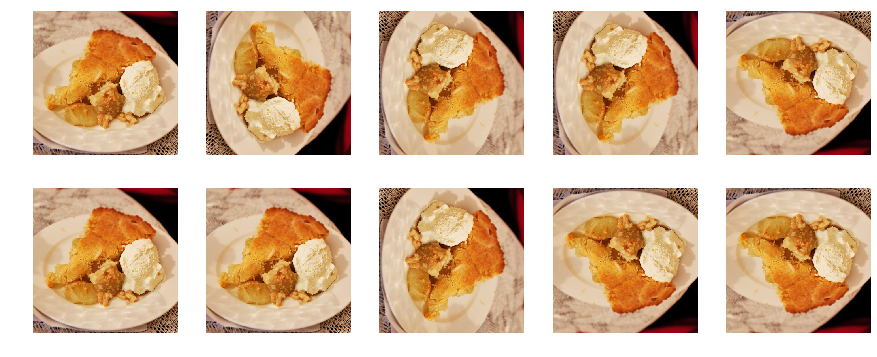

In [17]:
[open_image(path_train/'apple_pie/727412.jpg').apply_tfms(data.train_ds.tfms[1]).show(ax=ax) for i, ax in 
    enumerate(plt.subplots(2,5, figsize=(15,6))[1].flatten())];

Here we take a slice of pie and flip it upsidown. Does this really make sense? The challenge here is that we have certain images in the dataset that work with vertical flipping, and certain images that don't. In playing around with this dataset I experimentally found that including vertical flipping produced slightly better results, so I decided to keep it in the augmentation list.

# Augmentation 2: Symmetric Warp

This function applies different degrees of symmetric warping to the image. If you look at the bottom right corner of some of these images, you can see where pixels have been reflected to account for the image warping.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


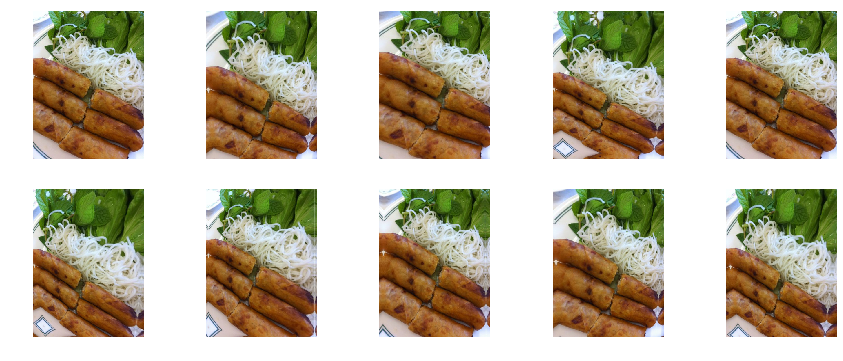

In [20]:
plots_f_indiv(2, 2, 5, 15, 6)

# Augmentation 3: Rotation

This augmentation applies a subtle rotation to the image (subtle relative to the full 90° flips of the dihedral affine transformation). I found that setting the maximum rotation to 10° produced good results. The augmented image will be rotated by up to 10° clockwise or counterclockwise.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


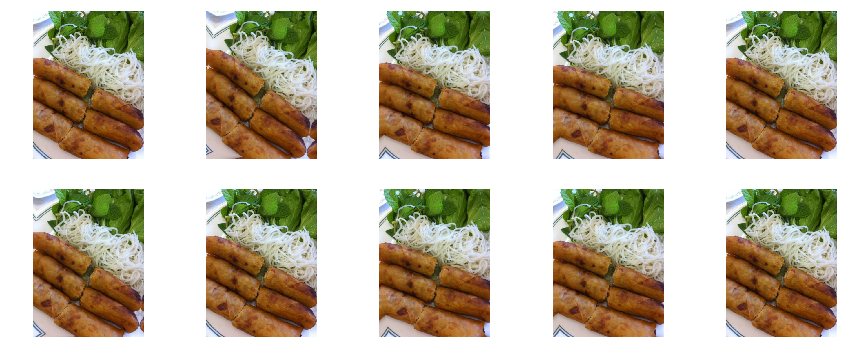

In [21]:
plots_f_indiv(3, 2, 5, 15, 6)

# Augmentation 4: Zoom

This function randomly zooms up to 1.1x the original image. Experimentally I found that higher zooms worked poorly for the dataset. As we saw in the previous notebook, many images in the dataset are not centered. Applying too large of a zoom risks cropping out important parts of the image.

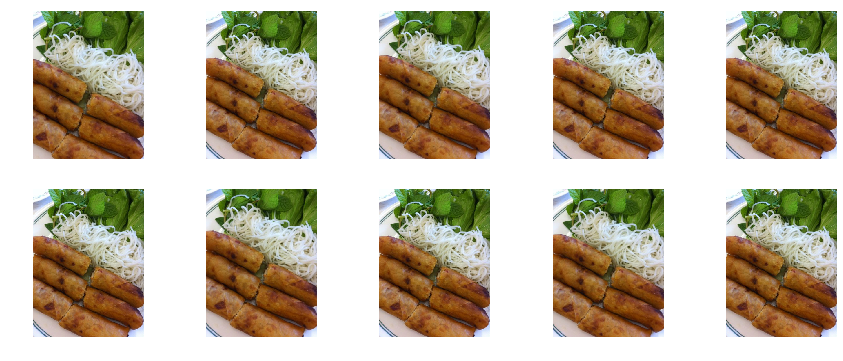

In [22]:
plots_f_indiv(4, 2, 5, 15, 6)

# Augmentation 5: Brightness

This is also a rather subtle augmentation, but important for getting good results. Brightness here is defined by a value between 0 and 1, where 0 transforms the image to black and 1 transforms the image to white. A change of 0.5 does nothing. I found experimentally that adding brightness augmentation helps a lot with accuracy on this dataset. This is likely because many images are overexposed or underexposed, and adding a brightness augmentation can help counteract this. However this also means that we need to be careful in how much we augment brightness. Underexposed images can be made darker, or overexposed images lighter.

I found that letting brightness coefficient vary from 0.375 to 0.625 produced good results.

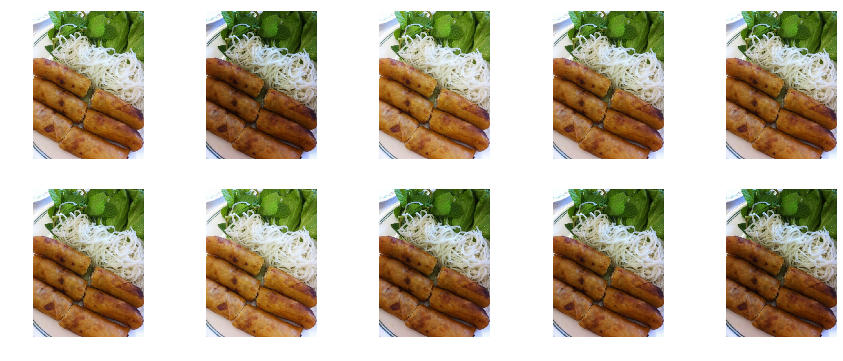

In [23]:
plots_f_indiv(5, 2, 5, 15, 6)

# Augmentation 6: Contrast

Similar to brightness, contrast is defined by a value between 0 and 1 where 0 is greyscale, 1 is no change, and a value greater than 1 leads to super-contrast. Also similar to brightness, we need to be careful with how much contrast we apply. The right amount yields great results, while too much hurts performance.

I found letting contrast vary from 0.75 to 1.33 produced good results.

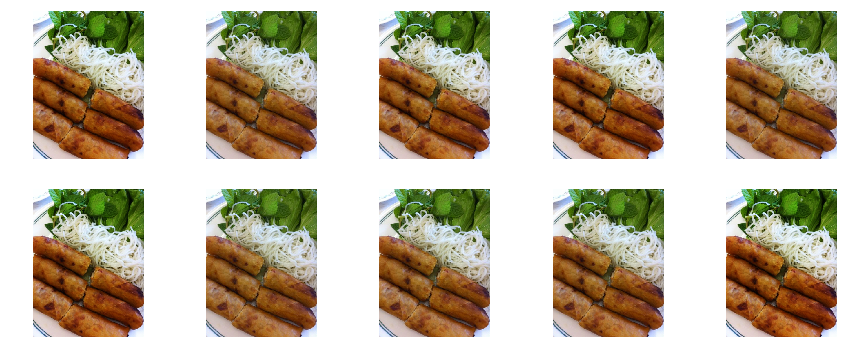

In [24]:
plots_f_indiv(6, 2, 5, 15, 6)

# Model Training

With our augmentations in hand, we can proceed to training the model. With a dataset of this size, training from scratch would likely lead to overfitting and disaster. To avoid this, we will start with a pre-trained Resnet-50 model.

To transfer the pre-trained model to the Food-101 dataset, we will replace the final linear layers at the end of the model with ones compatible for the Food-101 dataset's 101 classes. We will then train the model in two phases.

First we will freeze the pretrained weights of the model and train only the new linear layers we added to the model. We do this because the linear layers are totally untrained and naive, so allowing those layers to backpropagate gradients into the well tuned pretrained layers of the model will likely do more harm than good. We want to train the linear layers to a point where they are performing decently before retraining the entire model.

Second, we unfreeze the entire model and train with discriminative learning rates. This means we will train the early layers of the model at a lower learning rate than the higher layers. We do this because the early layers only do fundamental feature extraction - identifying curves, edges, changes in intensity, etc. These layers are already well tuned and don't need to be aggressively trained. The later layers, which are trained to extract information for Imagenet classes, will be retrained at a higher learning rate. The final linear layers will receive the highest learning rate.

We instantiate the model with a `Learner` object from the fast.ai library.

In [12]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

When we created the learner, several defaults were passed to the model that are worth noting. Firstly, we will be using a weight decay coefficient of 1e-2. With respect to weight decay, the fast.ai library implements weight decay using the gradient update format rather than the L2 regularization format.

The L2 regularization format adds the weight decay term directly to the loss:

$L_{\text total} = \Big(L + \lambda||w||_2^2\Big)$

While the gradient update format only adds in the weight decay term when the weights are updated:

$w_{i+1} = w_i - 2 \lambda w_i - \Big<\frac{\delta L}{\delta w}|_{w_i}\Big>$

If you use a simple optimizer like SGD, these methods are equivalent. However, we will be training with the Adam optimizer, which accumulates gradients over multiple timesteps. When we add in gradient accumulation to our optimizer, the two weight decay formats become different. With the L2 Regularization format, the weight decay term is included in all our accumulated gradients. With the gradient update format, weight decay does not impact the gradients. 

The impact of this effect was explored in [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101), which found the gradient update format produced better results.

In [27]:
learn.wd

0.01

We also defined the level of dropout we will use in the new linear head. Specifically the linear head looks like this:

In [28]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=101, bias=True)
)

We use dropout values of 0.25 and 0.5.

The full model looks like this:

In [29]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

For our loss function, we will use standard cross entropy.

In [30]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

We will also train in FP16

In [31]:
learn = learn.to_fp16(dynamic=True);

To select our learning rate, we will use the learning rate finder utility in the fast.ai library. This sweeps through a wide range of possible learning rates, looking at how the loss evolves as a function of learning rate.

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Looking at the plot of loss vs learning rate, we see three distinct regions.

At a low learning rate, our loss is mostly flat. This range of learning rates is too low.

In the middle, we see a section where the learning rate starts to drop. This represents a good range of learning rates.

At the end, we see the loss start to increase again. This is the point where the learning rate is too high.

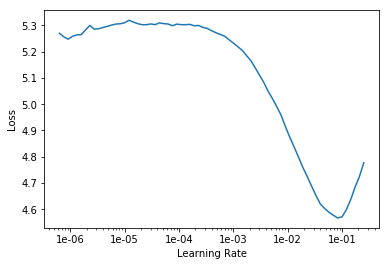

In [34]:
learn.recorder.plot(skip_end=9)

In [35]:
#Train linear head
learn.fit_one_cycle(4, max_lr=slice(1e-2))

In [36]:
learn.save('food_aug-1')

In [37]:
#learn.load('food_aug-1');

In [38]:
learn.unfreeze()

In [39]:
#Train entire model with discriminative learning rates / one cycle policy 
learn.fit_one_cycle(6, max_lr=slice(1e-5,1e-3))

In [40]:
learn.save('food_aug-2')

In [41]:
learn.load('food_aug-2');

We can use some useful methods from the fast.ai library to examine how our model performs.

In [44]:
interp = ClassificationInterpretation.from_learner(learn.to_fp32())
losses,idxs = interp.top_losses()

This plot shows the 'top losses' on the validation set. These are examples where the model was both wrong and highly confident in the wrong answer. The format of the titles for each subplot is `predicted category`/`correct category`/`loss`/`probability of correct category`.

The images are plotted with an overlay of the [Grad-CAM heatmap](https://arxiv.org/abs/1610.02391) for each image showing where large activations from the convolutional layers concentrate on the image.

Looking at this plot, we can see a number of problems we predicted. In the top left corner, we have oysters being confused for mussels - two very similar classes. On the bottom right there's confusion between macarons and donuts. Looking at the image I can understand why.

We also see mislabeled images! In the top middle, we have a photo of what is obviously a hamburger. The model predicts hamburger, but apparently the correct class is omelette? Turns out that image is `1186923.jpg` and according to the `train.json` file, the correct class for that image is omelette.

The mislabeling continues. In the top right, there's some sort of dessert. The model thinks it's cheesecake. I'm not sure, but it's definitely not onion rings, which is what the label apparently is. Sure enough, that's `1564732.jpg` and according to the json file the correct class is onion rings.

In the middle, the model confuses "beignets" for crab cakes. The actual image is `250043.jpg`. I can't tell exactly what is in the image, but it's paired with what looks like jalapeno peppers, so it's probably not actually a beignet. In the bottom middle there is `1782028.jpg`, "correct" class pulled pork sandwich even though it's only a picture of fries.

Bad labels aside, there are some true mistakes. On the bottom left, there's an image where the model zeros in on onion rings and classifies the image as a pulled pork sandwich. Not great.

But overall it looks like the top losses - the images where the model was most confident in the wrong prediction - are dominated by incorrect labels and close classes.

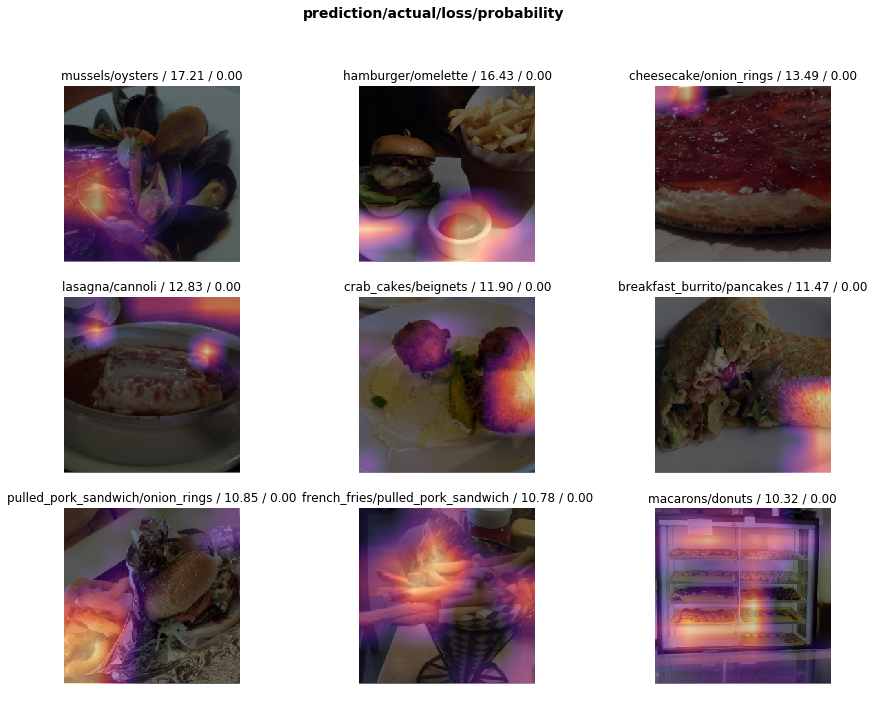

In [45]:
interp.plot_top_losses(9, figsize=(15,11))

Aside from the magnitude of the loss, we can look at the classes the model is most likely to confuse. Here we really see the impact of similar classes. Chocolate cake vs chocolate mousse. Steak vs filet mignon. Steak vs prime rib. Sashimi vs sushi. Beef tartare vs tuna tartare. These are the mixups that will be difficult to iron out.

In [72]:
interp.most_confused(min_val=4)

[('chocolate_cake', 'chocolate_mousse', 12),
 ('filet_mignon', 'steak', 9),
 ('dumplings', 'gyoza', 8),
 ('prime_rib', 'steak', 7),
 ('ice_cream', 'chocolate_mousse', 6),
 ('pulled_pork_sandwich', 'hamburger', 6),
 ('chocolate_mousse', 'chocolate_cake', 5),
 ('chocolate_mousse', 'tiramisu', 5),
 ('huevos_rancheros', 'breakfast_burrito', 5),
 ('sashimi', 'sushi', 5),
 ('shrimp_and_grits', 'risotto', 5),
 ('steak', 'filet_mignon', 5),
 ('steak', 'pork_chop', 5),
 ('sushi', 'sashimi', 5),
 ('beef_tartare', 'tuna_tartare', 4),
 ('chocolate_mousse', 'ice_cream', 4),
 ('gnocchi', 'ravioli', 4),
 ('gyoza', 'dumplings', 4),
 ('ice_cream', 'frozen_yogurt', 4),
 ('prime_rib', 'filet_mignon', 4),
 ('ravioli', 'gnocchi', 4),
 ('red_velvet_cake', 'cup_cakes', 4),
 ('scallops', 'foie_gras', 4),
 ('strawberry_shortcake', 'cheesecake', 4),
 ('tuna_tartare', 'beef_tartare', 4)]

# Training on 512x512

Now we move to training on 512x512 images. We will follow a similar strategy. First we will train only the linear head. Then we will unfreeze and train the entire model.

In [13]:
# Important to set the seed for the random split to get the same validation set
data_hr = (ImageList.from_folder(path_train).split_by_rand_pct(0.07, seed=42)
                                       .label_from_folder(classes=None)
                                       .transform(tfms=tfms, size=512)
                                       .databunch(bs=22, num_workers=6))

In [14]:
learn.data = data_hr
learn = learn.to_fp16(dynamic=True)
learn.freeze()

In [75]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


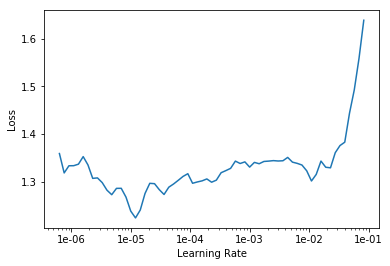

In [76]:
learn.recorder.plot(skip_end=10)

In [77]:
learn.fit_one_cycle(3, max_lr=slice(1e-3))

In [78]:
learn.save('food_aug-3')

In [15]:
learn.load('food_aug-3');
learn = learn.to_fp16(dynamic=True);
learn.unfreeze()

In [16]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

In [17]:
learn.save('food_aug-4')

In [11]:
learn.load('food_aug-4')
learn.unfreeze()

In [18]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

In [21]:
learn.save('food_aug-5')

I decided to stop training here. We've reached a point where the training loss is starting to really drop while the validation loss stays more or less constant. If we kept training beyond this point I expect we would see the train loss drop even more, while the validation loss starts to diverge. Now we can move onto prediction.



# Prediction

We will predict on the test set twice - once without TTA and once with TTA.

## Prediction Without TTA

This is pretty straightforward. We create a new dataloader that includes the test set, then we make our predictions.

In [22]:
data_test = (ImageList.from_folder(path/'data').split_by_folder(train='train', valid='test')
                                       .label_from_folder(classes=None)
                                       .transform(tfms=tfms, size=512)
                                       .databunch(bs=64, num_workers=6))

In [23]:
learn.data = data_test

In [24]:
learn.data

ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ..\data\food-101\data;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ..\data\food-101\data;

Test: None

In [25]:
learn = learn.to_fp32()

In [26]:
preds, y = learn.get_preds()

In [27]:
accuracy(preds, y)

tensor(0.8853)

Prediction without TTA gets us to 88.53% accuracy

## Prediction with TTA

Now we predict using TTA. This process will perform 9 predictions. One set of predictions will be on the test set without augmentations. The remaining 8 predictions will be on augmented versions of the test set images. Our final prediction is generated by linearly interpolating between the unaugmented prediction and the average of the augmented predictions. We use the parameter `beta` to control the interpolation. With `beta = 0.4`, we take 40% of the unaugmented prediction and 60% of the average of the augmented predictions.

In [28]:
preds_tta, y_tta = learn.TTA(beta=0.4, scale=1.05)

In [30]:
accuracy(preds_tta, y_tta)

tensor(0.8926)

Using TTA we increase our accuracy from 88.53% to 89.26%.

# Interpreting Predictions

Top-1 accuracy is the standard metric for evaluating on the Food-101 dataset, but it's important to to look beyond the single number to assess how the model is really performing. Our model has 89.26% accuracy on a test dataset of 25250 images - that works out to 2711 incorrect predictions. We should try look into those.

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

# Test Set Top Losses

I've plotted the top losses here without heatmaps for clarity. Again we see mislabeled examples dominating the top losses. 

In the top row:
`1713987.jpg` is definitely not pho.
`185194.jpg` might have macaroni and cheese in the background, but that's definitely some sort of tartare in the foreground.
`2765133.jpg` shows an omelette, fruit and panacakes, but not deviled eggs.

In the middle row:
`2508636.jpg` is a burger and fries, not a pizza.
`1008491.jpg` is absolutely and omelette, not a pancake
`3065825.jpg` is fried something, but definitely not an omelette

In the bottom row:
`1856233.jpg` is a pizza, not a chicken quesadilla
`2956362.jpg` this image I legitimately can't tell what it is, so I'll assume it actually is beef tartare and the model make a mistake
`3450123.jpg` I don't know what this is but it isn't a cheesecake.

So likely 8/9 images in the top losses are due to mislabeling.

With all of these, my initial assumption was that I had made some mistake when splitting out the test set. But after identifying all image filenames and cross checking them with the `test.json` file, they all match the incorrect class. This highlights the small but nonzero amount of label noise in the test dataset.

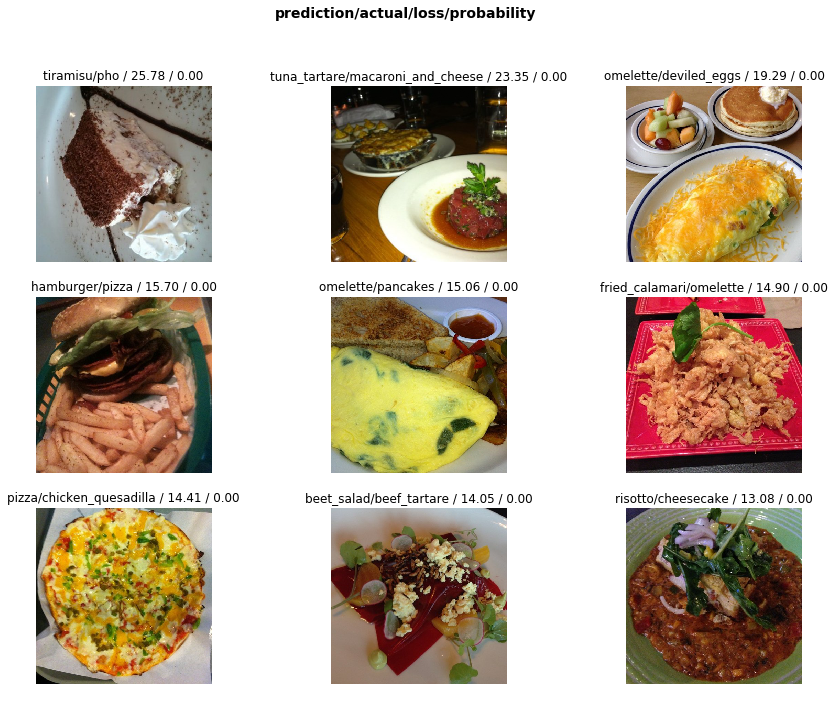

In [49]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

Looking at the top losses really only shows us a handfull of mislabeled examples. Looking at areas where the model is frequently confused gives a much more interesting look into performance and regions of failure. 

The model is frequently mixing up cuts of meat. Mixups involving steak, filet mignon, pork chops, prime rib and baby back ribs account for about 9% of total errors. Beef tartare vs tuna tartare is still a problem.

Dessert mixups are also common. Chocolate cake vs chocolate mousse. Bread pudding vs apple pie.

It's hard to think of good ways to make the model robust to these similar classes without training on more data.

In [50]:
interp.most_confused(min_val=9)

[('steak', 'filet_mignon', 39),
 ('filet_mignon', 'steak', 33),
 ('chocolate_mousse', 'chocolate_cake', 28),
 ('tuna_tartare', 'beef_tartare', 22),
 ('chocolate_cake', 'chocolate_mousse', 21),
 ('pork_chop', 'steak', 19),
 ('steak', 'prime_rib', 19),
 ('bread_pudding', 'apple_pie', 17),
 ('dumplings', 'gyoza', 17),
 ('apple_pie', 'bread_pudding', 16),
 ('beef_tartare', 'tuna_tartare', 16),
 ('prime_rib', 'steak', 16),
 ('club_sandwich', 'grilled_cheese_sandwich', 14),
 ('breakfast_burrito', 'huevos_rancheros', 13),
 ('huevos_rancheros', 'breakfast_burrito', 13),
 ('ice_cream', 'frozen_yogurt', 13),
 ('pork_chop', 'filet_mignon', 13),
 ('grilled_cheese_sandwich', 'club_sandwich', 12),
 ('steak', 'pork_chop', 12),
 ('falafel', 'crab_cakes', 11),
 ('tiramisu', 'chocolate_cake', 11),
 ('baby_back_ribs', 'steak', 10),
 ('cheesecake', 'tiramisu', 10),
 ('chicken_quesadilla', 'breakfast_burrito', 10),
 ('gnocchi', 'ravioli', 10),
 ('hamburger', 'pulled_pork_sandwich', 10),
 ('pulled_pork_sand

# TSNE Projections

Another interesting way of looking at predictions is to see how they cluster in space when TSNE is applied. We will run TSNE on the prediction vectors from the TTA prediction. These vectors have already been put through the softmax for prediction, meaning they all have one top class value that's close to one. As a result of this, we expect all the vectors of a similar class to cluster well. This will lead to more interesting results when we see vectors deviate from their class clusters.

In [35]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import manifold, datasets
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import squareform
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import NullFormatter
import PIL

In [36]:
probs_trans = manifold.TSNE(n_components=2, perplexity=15).fit_transform(preds_tta)

In [ ]:
prob_df = pd.DataFrame(np.concatenate((probs_trans, y[:,None]), axis=1), columns=['x','y','labels'])

This is a cluster over all 25250 predictions, colored by true class. We see lots of well defined class clusters, as we would expect, as well as a few rogue examples falling into the wrong class cluster.

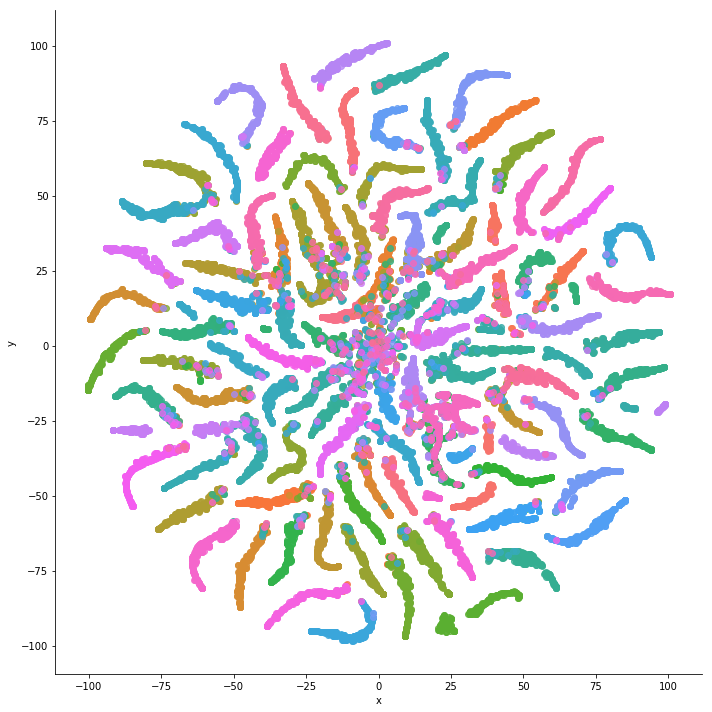

In [38]:
g = sns.lmplot('x', 'y', data=prob_df, hue='labels', fit_reg=False, legend=False, height=10)

Looking at all predictions at once creates a really busy graph. Lets break things down into just a few categories. Here we'll look at the predictions for steak, filet mignon, tuna tartare, beef tartare, prime rib and pork chop classes (label based on the true image label, not the prediction). These classes were chosen as the model frequently confuses them.

In [39]:
cats = ['steak', 'filet_mignon', 'tuna_tartare', 'beef_tartare', 'prime_rib', 'pork_chop']

codes = [data_test.classes.index(i) for i in cats]

bad_preds = [preds_tta[y==i] for i in codes]
bad_ys = [y_tta[y==i] for i in codes]

preds_stack = torch.cat(bad_preds, dim=0)
ys_stack = torch.cat(bad_ys, dim=0)

In [40]:
bad_tsne = manifold.TSNE(n_components=2, perplexity=6).fit_transform(preds_stack)

In [41]:
bad_df = pd.DataFrame(np.concatenate((bad_tsne, ys_stack[:,None]), axis=1), columns=['x','y','labels'])

As expected, we see lots of cluster mixing between classes. Each class has regions where the cluster is well defined, and regions where the cluster dissolves and mixes with other classes. This is another way of visualizing the confusion between classes.

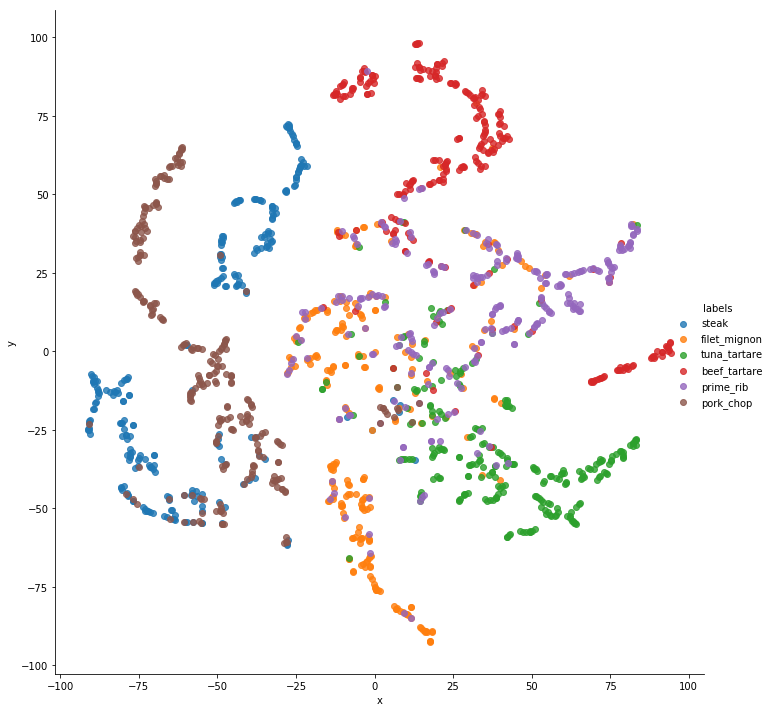

In [42]:
h = sns.lmplot('x', 'y', data=bad_df, hue='labels', fit_reg=False, legend=True, height=10)
for t, l in zip(h._legend.texts, cats): t.set_text(l)


For comparison lets take classes that don't get frequently confused.

In [43]:
cats = ['red_velvet_cake', 'risotto', 'waffles', 'apple_pie', 'garlic_bread', 'french_fries']

codes = [data_test.classes.index(i) for i in cats]

bad_preds = [preds_tta[y==i] for i in codes]
bad_ys = [y_tta[y==i] for i in codes]

preds_stack = torch.cat(bad_preds, dim=0)
ys_stack = torch.cat(bad_ys, dim=0)

In [44]:
bad_tsne = manifold.TSNE(n_components=2, perplexity=10).fit_transform(preds_stack)

In [45]:
bad_df = pd.DataFrame(np.concatenate((bad_tsne, ys_stack[:,None]), axis=1), columns=['x','y','labels'])

While the clustering isn't perfect, we see much better cluster definition here compared to the previous plot. 

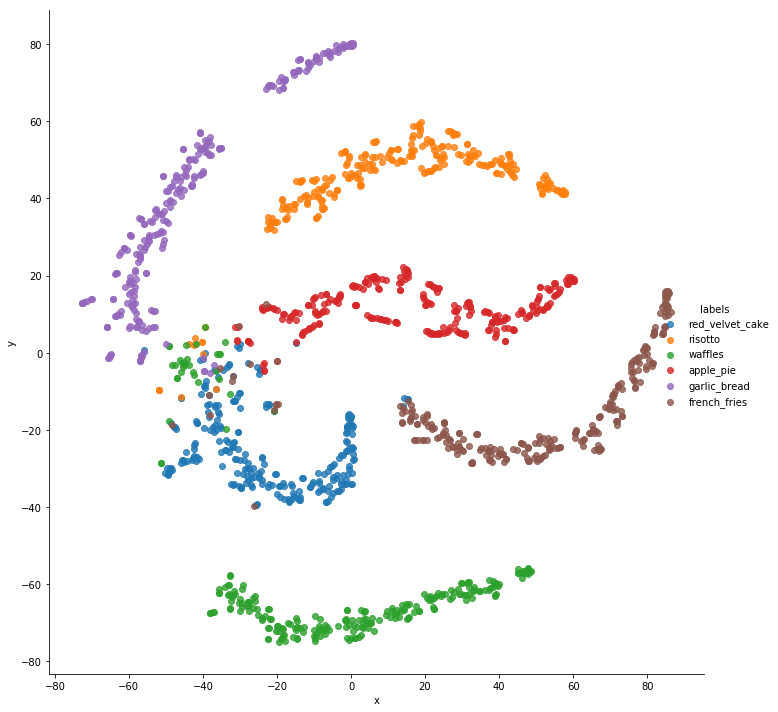

In [46]:
h = sns.lmplot('x', 'y', data=bad_df, hue='labels', fit_reg=False, legend=True, height=10)
for t, l in zip(h._legend.texts, cats): t.set_text(l)
